# Dimensionality Reduction: Pitfalls

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume.pylab as p3
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from IPython.display import YouTubeVideo

In [2]:
pca = PCA()

mpl.rcParams.update({'font.size':16})

# A function for plotting 3-dimensional data
def plot3d(df):
    data = df.values
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*data[:,0:3].T)
    minn,maxx = data.min(),data.max()
    ax.set_xlim(minn,maxx)
    ax.set_ylim(minn,maxx)
    ax.set_zlim(minn,maxx)
    ax.set_xlabel(df.columns[0],labelpad=10)
    ax.set_ylabel(df.columns[1],labelpad=10)
    ax.set_zlabel(df.columns[2],labelpad=10)
    ax.dist = 12
    plt.tight_layout()
    
def plot3d_live(data):
    fig = p3.figure()
    q = p3.scatter(*data.T, size=1, marker="sphere")
    p3.style.use("dark") # looks better
    p3.show()
        
# A function for summarizing covariancs and correlations
def summarize(info,name,quiet=False):
    values = info[name]
    if not quiet:
        print(values.round(2))
    plt.pcolor(values,cmap='RdBu_r',vmin=-values.max(),vmax=values.max())
    raynge = np.arange(values.shape[0])
    if not quiet:
        plt.xticks(raynge+0.5,raynge)
        plt.yticks(raynge+0.5,raynge)
    else:
        plt.xticks([])
        plt.yticks([])
    plt.gca().invert_yaxis() # Make y-axis go from low to high like a matrix
    plt.colorbar().set_label(name)
    if not quiet:
        eigenvalues,_ = np.linalg.eig(info[name])
        for i,eig in enumerate(sorted(eigenvalues,reverse=True)):
            print('Eigenvalue #%d is %.3g' % (i+1,eig))
        
def report_mean_var(data):
    for i in range(data.shape[1]):
        column = data[:,i]
        print("Dimension %d has mean %.2g and variance %.3g" % \
              (i+1,column.mean(),column.var()))
        
def annotate_scatter(ax,df):
    for i, text in enumerate(df.index):
        ax.text(df['PC 1'].iloc[i],df['PC 2'].iloc[i], text)
        
def variance_explained(df,pca):
    pca.fit(df.values)
    for i in range(min(*df.shape)):
        print("PC %d explains %.3g%% of the variance" % (i+1,100*pca.explained_variance_ratio_[i]))
        
def pc_report(pca,df):
    pca.fit(df.values)
    pca_df = pd.DataFrame(pca.components_.T,
                          index=df.columns,
                          columns=['PC %d' % (i+1) for i in range(min(*df.shape))])
    pca_df = pca_df.applymap(lambda x:'%.3g' % x)
    return pca_df

def plot_transformed_data(pca,df,figsize=None):
    pca.fit(df.values)
    pca_df = pd.DataFrame(pca.transform(df.values),
                      index=df.index,
                      columns=['PC %d' % (i+1) for i in range(min(*df.shape))])
    ax = pca_df.plot.scatter('PC 1','PC 2',figsize=figsize)
    annotate_scatter(ax,pca_df)

my_fake_data = np.random.rand(100,3)
my_fake_data[:,2] = (my_fake_data[:,0] + my_fake_data[:,1])/np.sqrt(2)

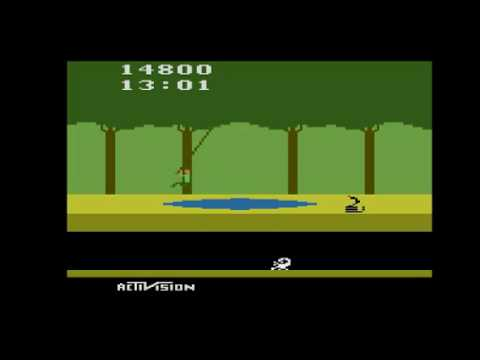

In [3]:
YouTubeVideo('MhXMYw1lXY0')

## Pitfall #1: Data has no structure to extract

In [4]:
df = pd.DataFrame(np.random.randn(500,3)) # Random data
plot3d_live(df.values) # Won't look interesting no matter what axes you use!

In [5]:
pca.fit(df.values)
variance_explained(df,pca)

PC 1 explains 37.3% of the variance
PC 2 explains 33.3% of the variance
PC 3 explains 29.4% of the variance


## Potential solution: Use more interesting data

## Pitfall #2: Dimensions have *very* unequal variances

In [6]:
df = pd.read_csv('data/crimedata.csv',delimiter='\t',thousands=',')

In [7]:
df = df.rename(columns=lambda x:x.replace('\n',' ').replace('  ',' '))
df = df.replace(20013,2001)
df = df.replace(20124,2012)
df = df.set_index('Year')

In [8]:
df.head()

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Year,,,,,
1994,260327021,1857670,713.6,23326,9.0
1995,262803276,1798792,684.5,21606,8.2
1996,265228572,1688540,636.6,19645,7.4
1997,267783607,1636096,611.0,18208,6.8
1998,270248003,1533887,567.6,16974,6.3


In [9]:
df.var()

Population1                                   3.355489e+14
Violent crime                                 3.457880e+10
Violent crime rate                            9.376104e+03
Murder and nonnegligent manslaughter          5.374923e+06
Murder and nonnegligent manslaughter rate     1.365132e+00
dtype: float64

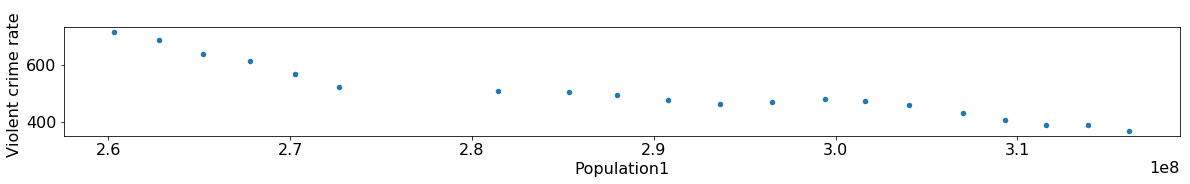

In [10]:
df.plot.scatter('Population1','Violent crime rate ',figsize=(20,2));

In [11]:
pca.fit(df.values)
variance_explained(df,pca)

PC 1 explains 100% of the variance
PC 2 explains 0.00178% of the variance
PC 3 explains 6.28e-08% of the variance
PC 4 explains 5.7e-12% of the variance
PC 5 explains 1.97e-16% of the variance


In [12]:
df.min()

Population1                                   260327021.0
Violent crime                                   1163146.0
Violent crime rate                                  367.9
Murder and nonnegligent manslaughter              14196.0
Murder and nonnegligent manslaughter rate             4.5
dtype: float64

## Potential solution: normalize each column to have values between 0 and 1

In [13]:
df_norm = (df - df.min())/(df.max() - df.min())

# OR

df_norm = df.copy()
df_norm[:] = MinMaxScaler().fit_transform(df.astype(float))

df_norm.head()

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Year,,,,,
1994,0.000000,1.000000,1.000000,1.000000,1.000000
1995,0.044376,0.915225,0.915823,0.811610,0.822222
1996,0.087839,0.756481,0.777264,0.596824,0.644444
1997,0.133626,0.680970,0.703211,0.439430,0.511111
1998,0.177790,0.533806,0.577668,0.304272,0.400000


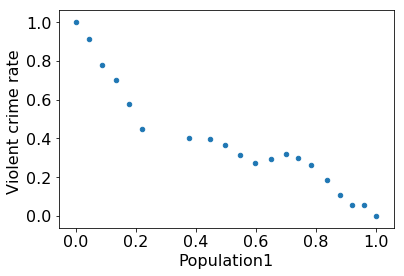

In [14]:
df_norm.plot.scatter(x='Population1',y='Violent crime rate ');

In [15]:
pca.fit(df_norm.values)
variance_explained(df_norm,pca)

PC 1 explains 93.8% of the variance
PC 2 explains 5.82% of the variance
PC 3 explains 0.289% of the variance
PC 4 explains 0.0443% of the variance
PC 5 explains 0.00281% of the variance


In [16]:
pc_report(pca,df_norm)

,PC 1,PC 2,PC 3,PC 4,PC 5
Population1,-0.51,-0.738,0.296,-0.328,-0.00958
Violent crime,0.44,-0.116,0.748,0.238,0.421
Violent crime rate,0.462,0.0712,0.257,-0.63,-0.564
Murder and nonnegligent manslaughter,0.393,-0.589,-0.242,0.506,-0.428
Murder and nonnegligent manslaughter rate,0.422,-0.301,-0.478,-0.427,0.567


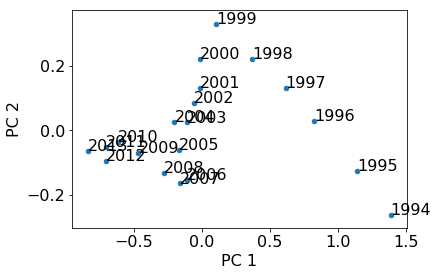

In [17]:
plot_transformed_data(pca, df_norm)

## Pitfall #3: Treating independent variables as measurements of interest

In [18]:
df = df.reset_index()
df.head()

,Year,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
0,1994,260327021,1857670,713.6,23326,9.0
1,1995,262803276,1798792,684.5,21606,8.2
2,1996,265228572,1688540,636.6,19645,7.4
3,1997,267783607,1636096,611.0,18208,6.8
4,1998,270248003,1533887,567.6,16974,6.3


## Potential solution: Move independent variables to the index

In [19]:
df = df.set_index('Year')
df.head()

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Year,,,,,
1994,260327021,1857670,713.6,23326,9.0
1995,262803276,1798792,684.5,21606,8.2
1996,265228572,1688540,636.6,19645,7.4
1997,267783607,1636096,611.0,18208,6.8
1998,270248003,1533887,567.6,16974,6.3


## Pitfall #4: Observations are highly correlated

In [20]:
df.corr().round(2)

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Population1,1.00,-0.91,-0.95,-0.76,-0.87
Violent crime,-0.91,1.00,0.99,0.95,0.98
Violent crime rate,-0.95,0.99,1.00,0.92,0.97
Murder and nonnegligent manslaughter,-0.76,0.95,0.92,1.00,0.98
Murder and nonnegligent manslaughter rate,-0.87,0.98,0.97,0.98,1.00


## Potential solution: Use changes in values instead of the original values

In [21]:
df_diff = df.diff().dropna()
df_diff.head()

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Year,,,,,
1995,2476255.0,-58878.0,-29.1,-1720.0,-0.8
1996,2425296.0,-110252.0,-47.9,-1961.0,-0.8
1997,2555035.0,-52444.0,-25.6,-1437.0,-0.6
1998,2464396.0,-102209.0,-43.4,-1234.0,-0.5
1999,2442810.0,-107843.0,-44.6,-1452.0,-0.6


In [22]:
df_diff.corr().round(2)

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Population1,1.00,0.29,0.12,0.26,0.13
Violent crime,0.29,1.00,0.98,0.86,0.80
Violent crime rate,0.12,0.98,1.00,0.88,0.85
Murder and nonnegligent manslaughter,0.26,0.86,0.88,1.00,0.98
Murder and nonnegligent manslaughter rate,0.13,0.80,0.85,0.98,1.00


In [23]:
df_diff_norm = (df_diff - df_diff.min())/(df_diff.max() - df_diff.min())

variance_explained(df_diff_norm,pca)

PC 1 explains 81.3% of the variance
PC 2 explains 12.2% of the variance
PC 3 explains 6.13% of the variance
PC 4 explains 0.264% of the variance
PC 5 explains 0.0707% of the variance


## Pitfall #5: Including other non-measurements in the "data"

In [24]:
df = pd.read_csv('data/2017shooting.csv')
df.head()

,RK,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,PPS,AFG%
0,1,114.4,39.4,85.6,0.460,15.7,43.2,0.364,19.9,25.2,0.792,1.34,0.552
1,2,105.7,37.8,86.7,0.436,11.9,34.0,0.348,18.2,23.9,0.761,1.22,0.504
2,3,109.7,39.6,83.9,0.472,12.0,32.8,0.365,18.6,23.2,0.801,1.31,0.543
3,4,102.5,38.1,84.5,0.451,11.6,31.9,0.365,14.7,19.0,0.774,1.21,0.520
4,5,111.3,40.9,87.4,0.468,11.2,31.8,0.351,18.4,22.9,0.804,1.27,0.532


## Potential solution: Get rid of those non-measurements

In [25]:
df = df.drop('RK', axis=1)
df.head()

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,PPS,AFG%
0,114.4,39.4,85.6,0.460,15.7,43.2,0.364,19.9,25.2,0.792,1.34,0.552
1,105.7,37.8,86.7,0.436,11.9,34.0,0.348,18.2,23.9,0.761,1.22,0.504
2,109.7,39.6,83.9,0.472,12.0,32.8,0.365,18.6,23.2,0.801,1.31,0.543
3,102.5,38.1,84.5,0.451,11.6,31.9,0.365,14.7,19.0,0.774,1.21,0.520
4,111.3,40.9,87.4,0.468,11.2,31.8,0.351,18.4,22.9,0.804,1.27,0.532


## Pitfall #6: Unlabeled data

In [26]:
df = pd.read_csv('data/basketball.csv')
df['Player'] = df['Player'].map(lambda x:x.split('\\')[0]) # Cleanup player names
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,1,Alex Abrines,SG,24.0,OKC,56,8,16.0,1.6,4.1,...,0.872,0.4,1.3,1.7,0.4,0.5,0.1,0.4,1.7,4.9
1,2,Quincy Acy,PF,27.0,BRK,54,8,20.7,1.8,5.3,...,0.821,0.7,3.5,4.1,0.8,0.5,0.4,1.0,2.1,5.8
2,3,Steven Adams,C,24.0,OKC,57,57,32.6,6.0,9.5,...,0.571,5.1,3.9,9.1,1.0,1.2,1.1,1.5,2.9,14.0
3,4,Bam Adebayo,C,20.0,MIA,51,11,20.5,2.7,4.8,...,0.732,1.6,3.8,5.4,1.6,0.5,0.6,0.9,2.1,7.4
4,5,Arron Afflalo,SG,32.0,ORL,45,2,12.8,1.2,3.0,...,0.833,0.1,1.3,1.4,0.6,0.0,0.2,0.4,1.1,3.2


## Potential solution: Labeled data

In [27]:
df = df.drop(['Player', 'Rk', 'Tm', 'Age'], axis=1).set_index(['Pos']).fillna(0)
df.head()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
Pos,,,,,,,,,,,,,,,,,,,,,
SG,56,8,16.0,1.6,4.1,0.384,1.1,3.0,0.367,0.5,...,0.872,0.4,1.3,1.7,0.4,0.5,0.1,0.4,1.7,4.9
PF,54,8,20.7,1.8,5.3,0.336,1.4,4.2,0.329,0.4,...,0.821,0.7,3.5,4.1,0.8,0.5,0.4,1.0,2.1,5.8
C,57,57,32.6,6.0,9.5,0.631,0.0,0.0,0.000,6.0,...,0.571,5.1,3.9,9.1,1.0,1.2,1.1,1.5,2.9,14.0
C,51,11,20.5,2.7,4.8,0.551,0.0,0.1,0.000,2.7,...,0.732,1.6,3.8,5.4,1.6,0.5,0.6,0.9,2.1,7.4
SG,45,2,12.8,1.2,3.0,0.388,0.5,1.3,0.386,0.7,...,0.833,0.1,1.3,1.4,0.6,0.0,0.2,0.4,1.1,3.2


In [28]:
df_norm = (df - df.min())/(df.max() - df.min())
df_norm.head()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
Pos,,,,,,,,,,,,,,,,,,,,,
SG,0.873016,0.125000,0.422343,0.155340,0.194313,0.384,0.261905,0.283019,0.367,0.051546,...,0.872,0.078431,0.120370,0.108280,0.038462,0.227273,0.041667,0.08,0.447368,0.156051
PF,0.841270,0.125000,0.550409,0.174757,0.251185,0.336,0.333333,0.396226,0.329,0.041237,...,0.821,0.137255,0.324074,0.261146,0.076923,0.227273,0.166667,0.20,0.552632,0.184713
C,0.888889,0.890625,0.874659,0.582524,0.450237,0.631,0.000000,0.000000,0.000,0.618557,...,0.571,1.000000,0.361111,0.579618,0.096154,0.545455,0.458333,0.30,0.763158,0.445860
C,0.793651,0.171875,0.544959,0.262136,0.227488,0.551,0.000000,0.009434,0.000,0.278351,...,0.732,0.313725,0.351852,0.343949,0.153846,0.227273,0.250000,0.18,0.552632,0.235669
SG,0.698413,0.031250,0.335150,0.116505,0.142180,0.388,0.119048,0.122642,0.386,0.072165,...,0.833,0.019608,0.120370,0.089172,0.057692,0.000000,0.083333,0.08,0.289474,0.101911


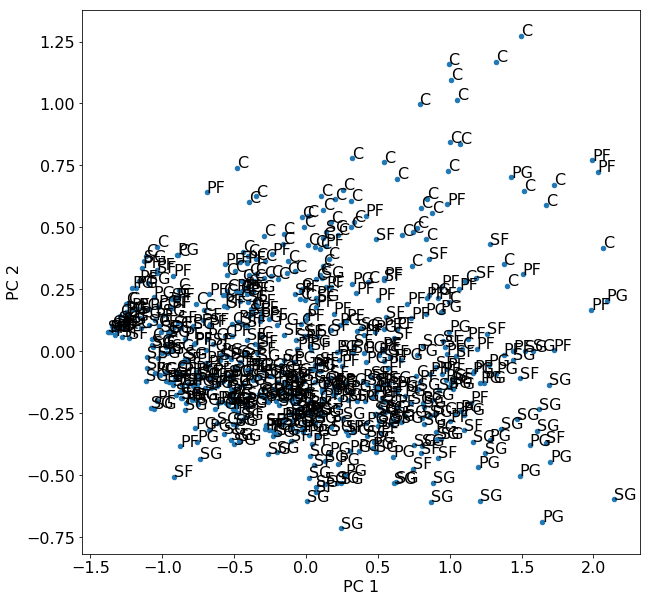

In [29]:
plot_transformed_data(pca, df_norm, figsize=(10,10))

## Pitfall #7: Too much data!

## Potential solution: Sparsen your data!

In [30]:
df = df[df['GS']>55] # Only consider players who have started at least 55 games
df.shape

(55, 25)

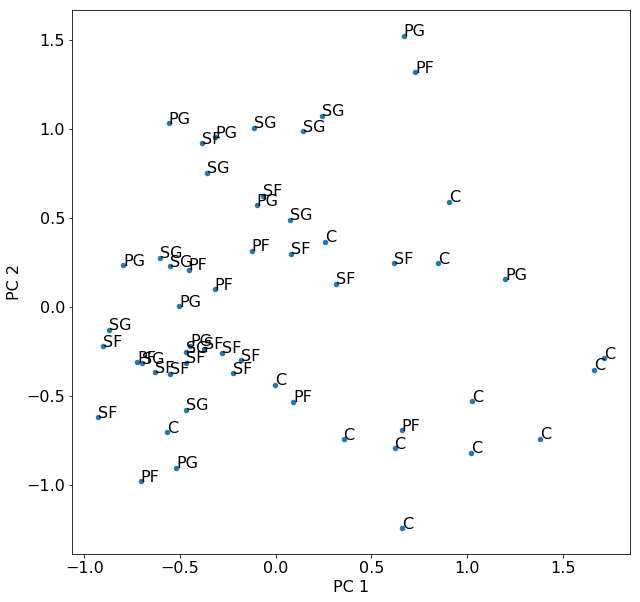

In [31]:
df_norm = (df - df.min())/(df.max() - df.min())
plot_transformed_data(pca, df_norm, figsize=(10,10))